# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [29]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [30]:
df.shape

(45993, 3)

In [31]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

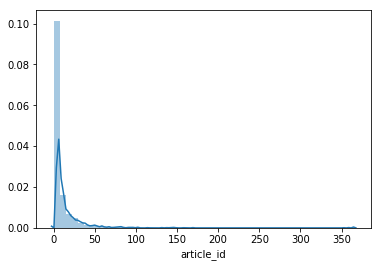

In [32]:
import seaborn as sns
sns.distplot(df.groupby('email').article_id.count())
# number of articles read by a user

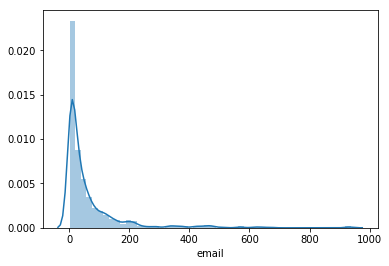

In [33]:
sns.distplot(df.groupby('article_id').email.count())
# number of users reading an article (the other way around)

In [34]:
article_by_user = df.groupby('email').article_id.count()
from scipy import stats
print('total number of users in the data: {}'.format(article_by_user.shape[0]))
print(stats.describe(article_by_user.values))
print('median number of articles a user reads is:{}'.format(article_by_user.median()))
print('20%,40%,60%,80% quantiles of number of articles a user reads are:{}'.format(np.quantile(article_by_user, [0.2,0.4,0.6,0.8])))

total number of users in the data: 5148
DescribeResult(nobs=5148, minmax=(1, 364), mean=8.930846930846931, variance=282.3161805920695, skewness=7.029412167323888, kurtosis=95.50262528225683)
median number of articles a user reads is:3.0
20%,40%,60%,80% quantiles of number of articles a user reads are:[ 1.  2.  5. 11.]


In [35]:
user_by_article = df.groupby('article_id').email.count()
from scipy import stats
print('total number of articles in the data: {}'.format(user_by_article.shape[0]))
print(stats.describe(user_by_article.values))
print('median number of readers per article is:{}'.format(user_by_article.median()))
print('20%,40%,60%,80% quantiles of number of readers per article are:{}'.format(np.quantile(user_by_article, [0.2,0.4,0.6,0.8])))

total number of articles in the data: 714
DescribeResult(nobs=714, minmax=(1, 937), mean=64.3921568627451, variance=11916.224678931881, skewness=3.7175429298253637, kurtosis=17.902587208340787)
median number of readers per article is:25.0
20%,40%,60%,80% quantiles of number of readers per article are:[ 6. 17. 38. 89.]


* Both the distributions of number of articles read by a user and number of users reading an article follow a long tail shape. 
* The average number of articles a user read is about 9. But the median number is only 3, which means half of the users read less or equal to 3 articles. The rest half of users read number of articles ranging from 3 to 364 with very high variance.
* The average number of times an article is read by a user is about 64. half of the articles are read less equal to 25 times. minimum read time is only once, and popular articles are read up to 937 times. 

In [36]:
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [37]:
df_content.columns

Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id'],
      dtype='object')

In [38]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['doc_description', 'doc_full_name','article_id'], keep= False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [39]:
df_content[df_content.duplicated(subset=['article_id'], keep= False)].sort_values(by=['article_id'])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [40]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'],keep='first', inplace=True)

In [41]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [42]:
df.email.isnull().sum() #17 null users

17

In [43]:
df.loc[df.email.notnull(), 'email'].unique().shape[0] # unique users

5148

In [44]:
df.article_id.unique().shape[0] # unique articles

714

In [45]:
df_content.article_id.unique().shape[0] #total unique articles

1051

In [46]:
#df[df.email.notnull()].shape[0]
df.shape[0]

45993

In [47]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions =45993 #45976 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [48]:
user_by_article[user_by_article==user_by_article.max()]

article_id
1429.0    937
Name: email, dtype: int64

In [49]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [50]:
# map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded


In [51]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [52]:
np.unique(df.loc[df.article_id.isin([1430, 1314]),'title'])

array(['healthcare python streaming application demo',
       'using pixiedust for fast, flexible, and easier data analysis and experimentation'],
      dtype=object)

In [53]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [54]:
user_by_article = df.groupby('title').user_id.count()
user_by_article.sort_values(ascending=False).index[:10]

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')

In [55]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    user_by_article = df.groupby('title').user_id.count()
    top_articles = list(user_by_article.sort_values(ascending=False).index[:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    user_by_article = df.groupby('article_id').user_id.count()
    top_articles = list(user_by_article.sort_values(ascending=False).index[:n])
    
    return top_articles 
     
# Return the top article ids

In [56]:
print(get_top_articles(10))
print('\n')
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [57]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [58]:
df.user_id.max()

5149

In [59]:
user_article_pivot = df.groupby(['user_id','article_id']).count().unstack()
#user_article_pivot = user_article_count.values.apply(lambda x: 1 if x>=1 else 0 )
user_article_pivot[np.isnan(user_article_pivot)] = 0
user_article_pivot[user_article_pivot>=1] = 1

In [60]:
user_article_pivot.loc[1].sum(axis=0)

36.0

In [61]:
df.loc[df.user_id==1, 'article_id'].unique().shape

(36,)

In [62]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_article_pivot = df.groupby(['user_id','article_id']).count().unstack()
    user_article_pivot[np.isnan(user_article_pivot)] = 0 #articles user has not seen is 0 
    user_article_pivot[user_article_pivot>=1] = 1 # articles user has seen is 1 not matter how many times he/she read
    return user_article_pivot # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [63]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [64]:
import operator
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim_dict = dict()
    for user in user_item.index:
        if user != user_id:
            sim_dict[user] = user_item.loc[user_id].dot(user_item.loc[user])
            
    # sort by similarity
    sim_dict_sorted = sorted(sim_dict.items(), key=operator.itemgetter(1), reverse=True)
    # create list of just the ids
    most_similar_users = [i[0] for i in sim_dict_sorted]
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [65]:
user_item.loc[1].dot(user_item.loc[2])

2.0

In [66]:
sim_dict = dict()
for user in user_item.index[:10]:
    if user != 1:
        sim_dict[user] = user_item.loc[1].dot(user_item.loc[user])
            
    # sort by similarity
sim_dict_sorted = sorted(sim_dict.items(), key=operator.itemgetter(1), reverse=True)
print(sim_dict_sorted)
print([i[0] for i in sim_dict_sorted])
    # create list of just the ids
#most_similar_users = list(sim_dict_sorted.keys())

[(10, 7.0), (3, 6.0), (8, 6.0), (6, 4.0), (9, 4.0), (4, 3.0), (2, 2.0), (7, 1.0), (5, 0.0)]
[10, 3, 8, 6, 9, 4, 2, 7, 5]


In [67]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [68]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(np.unique(df.loc[df.article_id.isin(article_ids),'title']))
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    read_article = user_item.loc[user_id,user_item.loc[user_id].values==1].unstack()
    read_article_ids = list(read_article.columns.astype('U').values) 
    #returns list of int but assert test only treats article_id as string, so have to convert int to string
    read_article_names = list(get_article_names(read_article_ids,df))
    return read_article_ids, read_article_names # return the ids and names


def user_user_recs(user_id, m):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # get the articles a user_id read already
    read_article_ids, read_article_names = get_user_articles(user_id, user_item)
    # get the closest neighbor
    closest_neighbors = find_similar_users(user_id, user_item)
    recs= np.array([])
    for neighor in closest_neighbors:
        neighbor_article_id, neighbor_article_names = get_user_articles(neighor, user_item)
        #Get the article_id that the neighbor has seen but the user has not.
        new_recs = np.setdiff1d(neighbor_article_id, read_article_ids, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) >= m:
            break
    top_m_recs = list(recs[:m])
    
    return top_m_recs # return your recommendations for this user_id    

******* test cells for the functions

In [69]:
neighbor_article_id=[1,4,6,2]
read_article_ids= [1,4,6,2,10,3]
np.setdiff1d(read_article_ids, neighbor_article_id, assume_unique=True)[:1]
#np.setdiff1d(neighbor_article_id, read_article_ids, assume_unique=True)

array([10])

In [70]:
recs = []
new_recs = [5,2,3]

recs= np.unique(np.concatenate([new_recs, recs]))#np.unique(np.concatenate([new_recs, recs], axis=0))
recs
#np.unique(recs.append(new_recs), axis=0)

array([2., 3., 5.])

In [71]:
read_article = user_item.loc[1,user_item.loc[1].values==1].unstack()
read_article

article_id,43.0,109.0,151.0,268.0,310.0,329.0,346.0,390.0,494.0,525.0,...,1368.0,1391.0,1400.0,1406.0,1427.0,1429.0,1430.0,1431.0,1436.0,1439.0
title,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [72]:
read_article_id = read_article.columns.astype('U').values
print(read_article_id)
get_article_names(read_article_id,df)

['43.0' '109.0' '151.0' '268.0' '310.0' '329.0' '346.0' '390.0' '494.0'
 '525.0' '585.0' '626.0' '668.0' '732.0' '768.0' '910.0' '968.0' '981.0'
 '1052.0' '1170.0' '1183.0' '1185.0' '1232.0' '1293.0' '1305.0' '1363.0'
 '1368.0' '1391.0' '1400.0' '1406.0' '1427.0' '1429.0' '1430.0' '1431.0'
 '1436.0' '1439.0']


['access db2 warehouse on cloud and db2 with python',
 'analyze db2 warehouse on cloud data in rstudio in dsx',
 'apache spark lab, part 1: basic concepts',
 'categorize urban density',
 'classify tumors with machine learning',
 'country statistics: life expectancy at birth',
 'deep learning with tensorflow course by big data university',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'introducing ibm watson studio ',
 'introduction to market basket analysis in\xa0python',
 'jupyter notebook tutorial',
 'new shiny cheat sheet and video tutorial',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning',
 'python for loops explained (python for data science basics #5)',
 'python if statements explained (python for data science basics #4)',
 'rapidly build machine learning fl

In [73]:
list(get_user_articles(20)[0])

['232.0', '844.0', '1320.0']

In [74]:
# Check Results
get_article_names(user_user_recs(1, m=10)) # Return 10 recommendations for user 1

['1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'a tensorflow regression model to predict house values',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings',
 'analyze facebook data using ibm watson and watson studio',
 'data tidying in data science experience',
 'recommender systems: approaches & algorithms']

In [75]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['232.0', '844.0','1320.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [76]:
len(get_user_articles(1)[0])

36

In [77]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # get the closest neighbor id list in similarity high to low order
    sim_dict = dict()
    article_by_user = df.groupby('user_id').article_id.count()
    for user in user_item.index:
        if user != user_id:
            sim_dict[user] = {'similarity':user_item.loc[user_id].dot(user_item.loc[user]),'article_interation': article_by_user.loc[user]}
            
    # map the user id to their similarity scores, use get_user_articles function to get the count of article interations
    # store the 2 values under the user_id key in the dict
    similar_users = [i for i in sim_dict]
    similarity_score = [sim_dict[i]['similarity'] for i in sim_dict]
    article_interation = [sim_dict[i]['article_interation'] for i in sim_dict]
    
    # create the df with the 3 columns
    neighbors_df = pd.DataFrame({'neighbor_id': similar_users,'similarity':similarity_score,'num_interactions': article_interation })
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
  # Return the dataframe of similar users to the input user_id order by simiarity score and article interaction descending
    return neighbors_df 



In [78]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    # articles read by this user
    read_article_ids, read_article_names = get_user_articles(user_id, user_item)
    # get the whole article list in descending order by num of read times, convert to string from int
    top_article_id = list(np.array(get_top_article_ids(df.article_id.unique().shape[0], df)).astype('U'))
    recs= np.array([])
    for neighor in neighbors_df.neighbor_id:
        neighbor_article_id, neighbor_article_names = get_user_articles(neighor, user_item)
        new_recs = np.setdiff1d(neighbor_article_id, read_article_ids, assume_unique=True)
        # get the ranking/index of new_recs. the smaller the index, the higher the ranking
        new_recs_indx = [top_article_id.index(i) for i in new_recs]
        # sort new_recs by new_recs_indx - popularity of articles
        new_recs_sortedby_popularity = [x for _,x in sorted(zip(new_recs_indx, new_recs))]
        # append to the recs list
        recs = np.unique(np.concatenate([new_recs_sortedby_popularity, recs], axis=0))
        if len(recs) >= m:
            break
    recs = recs[:m]
    rec_names = get_article_names(recs, df)
        
    return recs, rec_names

In [79]:
top_article_id = np.array(get_top_article_ids(10,df))
list(top_article_id.astype('U'))

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [80]:
# test
list1 = get_top_article_ids(100,df)
art = [164.0,812.0,1314.0, 43.0]
indx = [list1.index(i) for i in art]
[x for y,x in sorted(zip(indx, art))]

[1314.0, 43.0, 164.0, 812.0]

In [81]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: chicago listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'using deep learning to reconstruct high-resolution audio']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [82]:
get_top_sorted_users(1, df=df, user_item=user_item).head(10)

,neighbor_id,similarity,num_interactions
3931,3933,35.0,45
21,23,17.0,364
3780,3782,17.0,363
201,203,15.0,160
4457,4459,15.0,158
129,131,14.0,145
3868,3870,14.0,144
44,46,13.0,63
4199,4201,13.0,61
47,49,12.0,147


In [83]:
get_top_sorted_users(131, df=df, user_item=user_item).head(10)

,neighbor_id,similarity,num_interactions
3868,3870,74.0,144
3780,3782,39.0,363
22,23,38.0,364
201,203,33.0,160
4457,4459,33.0,158
97,98,29.0,170
3762,3764,29.0,169
48,49,29.0,147
3695,3697,29.0,145
240,242,25.0,148


In [84]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [85]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
For any new user, we can start the recommendation with the most popular articles from the top_article_id funtion, since we have no user-article interation history to do the user-user colloborative filtering. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [86]:
new_user = '0.0'

# for this new user '0.0' who have no observed articles
# we can recommend a list of the top 10 article using rank-based approach - suggest the top 10 most popular articles to start with
new_user_recs = list(np.array(get_top_article_ids(10, df)).astype('U'))
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [87]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

##### My approach to content-based recommendation is as follows:
1. Use article titles as the content base to do NLP and tf-idf transformation for getting a article content matrix
2. Calculate article - article cosine similarities based on the article content matrix
3. Get user viewed article ids
4. Get similar articles to viewed articles (use cosine similarity on the content matrix)
5. If similarity score is same then recommend based upon most viewed articles

In [94]:
df_articles = df[['article_id', 'title']].drop_duplicates(keep='first')
df_articles.head()

,article_id,title
0,1430.0,"using pixiedust for fast, flexible, and easier..."
1,1314.0,healthcare python streaming application demo
2,1429.0,use deep learning for image classification
3,1338.0,ml optimization using cognitive assistant
4,1276.0,deploy your python model as a restful api


In [100]:
df_articles.loc[0].title

'using pixiedust for fast, flexible, and easier data analysis and experimentation'

In [95]:
df_articles.shape # 714 unique articles

(714, 2)

In [114]:
# import NLP packages
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re

In [126]:
title_clean = []
for text in df_articles.title:
    # remove non-alphebetic contents, including punctuations, numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # standardize text with lower case and remove leading and trailing spaces
    clean_text = ' '.join(i.lower().strip() for i in text.split())
    title_clean.append(clean_text)
title_clean = np.array(title_clean)
title_clean[:5]

array(['using pixiedust for fast flexible and easier data analysis and experimentation',
       'healthcare python streaming application demo',
       'use deep learning for image classification',
       'ml optimization using cognitive assistant',
       'deploy your python model as a restful api'], dtype='<U96')

In [133]:
# vectorize the title column with tfidf
tfidf = TfidfVectorizer(stop_words='english')
article_mat = tfidf.fit_transform(title_clean).toarray()

In [134]:
article_mat = pd.DataFrame(article_mat, columns = tfidf.get_feature_names(), index = df_articles['article_id'])
print(article_mat.shape)
article_mat.head()

(714, 1254)


,abalone,accelerate,accelerates,access,accident,account,accounts,achievements,actions,activity,...,wrong,xgboost,xml,year,years,yolo,york,youtube,zctas,zip
article_id,,,,,,,,,,,,,,,,,,,,,
1430.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1314.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1429.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1338.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1276.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
article_mat.loc[1430.0][article_mat.loc[1430.0]>0]

analysis           0.322799
data               0.129874
easier             0.436489
experimentation    0.436489
fast               0.378349
flexible           0.436489
pixiedust          0.328320
using              0.237538
Name: 1430.0, dtype: float64

In [221]:
from collections import defaultdict
def make_content_recs(article_mat, user_id, m=10):
    '''
    INPUT:
    article_max - TFIDF transformed article title matrix
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Get the articles the given user_id has read, get the similar articles for each article the user has read.
    Rank by similarity desc. If two articles have the same similarity score, choose the one with higher views.
    Does this until m recommendations are found

    '''
    # get the articles this user has read

    read_article_ids, read_article_names = get_user_articles(10, user_item)
    read_article_ids = [float(artid) for artid in read_article_ids]

    sim_dict = defaultdict(list)
    article_views = df.groupby('article_id').user_id.count()
    
    # for each article the user has read, find its similar articles, insert into the list when similarity score>0
    # dict = {articleid_read_1: [{'neighbor_art_id': 12, 'similarity': 0.58, 'view_times':150}, {}],
    #         articleid_read_2: [{'neighbor_art_id': 28, 'similarity': 0.545, 'view_times':151}, {}]
    #        }
    for art_id in read_article_ids:
        for all_art in article_views.index:
            sim_score = article_mat.loc[art_id].dot(article_mat.loc[all_art])
            if sim_score>0 and art_id != all_art:
                sim_dict[art_id].append({'neighbor_art_id':all_art, 'similarity': article_mat.loc[art_id].dot(article_mat.loc[all_art]), 'viewed_times':article_views[all_art]})

    article_readby_uer = [i for i in sim_dict]
    neighbor_article_id = [sim_dict[i][j]['neighbor_art_id'] for i in sim_dict for j in range(len(sim_dict[i]))]
    similarity_score = [sim_dict[i][j]['similarity'] for i in sim_dict for j in range(len(sim_dict[i]))]
    viewed_times = [sim_dict[i][j]['viewed_times'] for i in sim_dict for j in range(len(sim_dict[i]))]
    
    # create the df with the 3 columns
    neighbors_df = pd.DataFrame({'neighbor_art_id': neighbor_article_id,'similarity':similarity_score,'viewed_times': viewed_times })
    # exclude the article_id in neighbor_article_id that have been read by user already
    neighbors_df = neighbors_df.loc[~neighbors_df['neighbor_art_id'].isin(read_article_ids),:]
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'viewed_times'], ascending=False)
    
    # Return the dataframe of similar users to the input user_id order by simiarity score and article interaction descending
    recommend_art_id = neighbors_df['neighbor_art_id'].unique()[:m]
    recommend_art_title = df_articles.loc[df_articles.article_id.isin(recommend_art_id),'title'].values
    return recommend_art_id , recommend_art_title       
            

In [223]:
user_id = 20
recommend_art_id , recommend_art_title  = make_content_recs(article_mat, user_id , m=10) 
print('content-based recommender would recommend article id to user {}: \n {} '.format(user_id, recommend_art_id))
print('\n')
print('content-based recommender would recommend article title to user {}: \n {}'.format(user_id, recommend_art_title))

content-based recommender would recommend article id to user 20: 
 [1304.  610. 1420.  555.  313.  805.  284.  124.  721.   54.] 


content-based recommender would recommend article title to user 20: 
 ['gosales transactions for logistic regression model'
 'use apache systemml and spark for machine learning'
 'python machine learning: scikit-learn tutorial'
 'machine learning for everyone' 'back to basics — jupyter notebooks'
 'what is machine learning?' 'the power of machine learning in spark'
 '8 ways to turn data into value with apache spark machine learning'
 'apache spark 2.0: machine learning. under the hood and over the rainbow.'
 'build a naive-bayes model with wml & dsx']


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

The content-based recommender I wrote uses the words in article titles as the basis to compute the similarity score between articles. Articles whose title has similar wording or vocabulary will be deemed as similar to each other. 

For each of the article the input user has read, the algorithm loops through all the articles in the dataset and their compute similarity scores against the article he read. When the similarity is larger than 0, the "similar" article_id, its similarity score will be recorded into a dictionary along with the number of times that similar article has been viewed. 

After finishing all the calculation, the dictionary will consist a list of articles the user has read as keys, and a list of potential similar articles as values for each article read. The similar articles, their similarity score and times they are viewed will then be consolidated into one data frame. Finally I make sure the data frame does not contain any similar articles the user has read, and get the top articles to recommend to that user by sorting the article_id by similarity and view_times in descending order. 

This content based recommender is good in recommending niche articles tailored to the users browsing history even though they are not very popular in general. For example, if the user has very unique taste and is very different from the rest of the users, then user-user collaborative filtering might find it hard to make recommendations. However, content based recommender does not have this issue, because it can recommend only based on the titles of the articles. 

The downside of content based recommender might be it would not make recommendations outside of the users' browsing history, or say "surprise" users with totally different recommendations that user might also like, unlike what the user-user collaborative filtering would do otherwise. 

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [67]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [68]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [69]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

In [70]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 5149)
(714,)
(714, 714)


**Provide your response here.**
The reaon why we can use SVD here instead of FunkSVD is that there is no missing value in this user_item_matrix. This matrix is made with the binary values where 1 means user has read the article and 0 means the user has not, while the movie rating matrix has missing values when the user has not given a rating to a movie. In essence, the difference between the user_item_matrix and movie_rating_matrix in lesson is that the absence of user- item interaction in former is represented by 0 and NaN in the latter. So it is ok to use SVD for this particular matrix.

*** suggestion to Udacity: give more clarification to this question. "different than the lesson" is very vague. be more specific with which part of the lesson and what you expect the students to answer.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

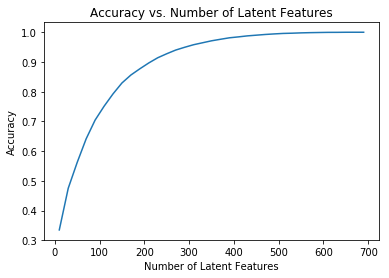

In [71]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [95]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [96]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.groupby(['user_id','article_id']).title.count().unstack()
    user_item_test  = df_test.groupby(['user_id','article_id']).title.count().unstack()
    
    user_item_train[np.isnan(user_item_train)] = 0
    user_item_train[user_item_train>=1] = 1
    user_item_test[np.isnan(user_item_test)] = 0
    user_item_test[user_item_test>=1] = 1
    
    train_idx = user_item_train.index.values
    train_arts = user_item_train.columns.values
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    return user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts

user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts = create_test_and_train_user_item(df_train, df_test)

In [97]:
print(user_item_train.shape)
print(user_item_test.shape)

(4487, 714)
(682, 574)


In [98]:
print(len(test_idx), len(test_arts) )

682 574


In [99]:
print(len(np.intersect1d(train_idx, test_idx ))) # number of user id in both train and test set
print(len(np.intersect1d(train_arts, test_arts))) # all articles are in both train and test 

20
574


In [100]:
np.intersect1d(train_idx, test_idx )

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

In [78]:
#user_item_test.loc[2917,:]

In [101]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c ,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d,# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [102]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

In [103]:
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [111]:
# overlap_user = np.intersect1d(train_idx, test_idx )
# overlap_user_index = np.where(np.isin(train_idx,overlap_user))[0]
overlap_user_index = user_item_train.index.isin(test_idx)
u_test = u_train[overlap_user_index,:] 
# get the index of overlapping user in train matrix, get the subset of u with those index
u_test.shape

(20, 4487)

In [114]:
# get the index of overlapping article in train matrix, get the subset of vt with those index
overlap_article = np.intersect1d(train_arts, test_arts)
overlap_article_index = np.where(np.isin(train_arts,overlap_article))[0]
vt_test = vt_train[:,overlap_article_index]
vt_test.shape

(714, 574)

In [106]:
# find the subset of user_item_test where user_id exist in user_item_train

#overlap_article_index_test = np.where(np.isin(test_arts,overlap_article))[0]
#overlap_user_index_test = np.where(np.isin(test_idx,overlap_user))[0]
user_item_test_subset = user_item_test.loc[overlap_user]
user_item_test_subset.shape

(20, 574)

In [107]:
user_item_test_subset.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
def choose_num_latent_feature (num_latent_feats):
    errs_list = [] 

    for k in num_latent_feats:
        
    # restructure with k latent features
        u_train_new, s_train_new, vt_train_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
        u_test_new, vt_test_new = u_test[:, :k] , vt_test[:k, :]
    # take dot product
        user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
        user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new),  vt_test_new))

    # compute error for each prediction to actual value
        diffs_train = np.subtract(user_item_train, user_item_train_pred)
        diffs_test = np.subtract(user_item_test_subset, user_item_test_pred)
    # total errors
        err_train = np.sum(np.sum(np.abs(diffs_train)))
        err_test = np.sum(np.sum(np.abs(diffs_test)))
        #sum_err = err_train+ err_test

        errs_list.append((err_train, err_test))
    
    return errs_list
    

In [148]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,570,10)
errs_list = choose_num_latent_feature(num_latent_feats)

In [149]:
train_errs_list = [x[0] for x in errs_list]
test_errs_list = [x[1] for x in errs_list]

In [163]:
num_latent_feats[5]

60

In [162]:
1 - np.array(train_errs_list[5])/(user_item_train.shape[0]*user_item_train.shape[1]) 

0.9951113050524422

In [164]:
1 - np.array(test_errs_list[5])/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]) 

0.974390243902439

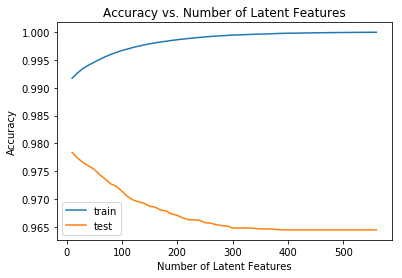

In [150]:
# this is the final chart
plt.plot(num_latent_feats, 1 - np.array(train_errs_list)/(user_item_train.shape[0]*user_item_train.shape[1]) );
plt.plot(num_latent_feats, 1 - np.array(test_errs_list)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]) );
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.legend(['train','test'])
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Since there were only 20 individuals who co-existed between the training and testing datasets, there isn't exactly a lot data that can be used to test how well predictions via collaborative filtering with SVD are matching up with actual values.

Though the above plot makes it look like we are doing great in terms of accuracy, this is largely due to the class imbalance of 1's and 0's. We actually only have 3 recommendations in the test set that were actually interactions that ended up happening. This is largely the hard part with recommendations for these situations.

As an alternative to the offline approach we used here, we could do an online approach where we run an experiment to determine the impacts of implementing one or more recommeandtion systems into our user base.

A simple experiment for this situation might be running a A/B test that is we randomly assign half of users to a control group that receives no recommendations (like currently is the case). A second group randomly receives recommendations using a mix of the methods provided above. We then measure the mean/median number of interactions by users in each group. We perform a hypothesis test where the null is that there is no difference in number of interactions against an alternative that there is a difference (or that the recommendation system increases the number of user-article interactions). We use some reasonable alpha level to understand if the recommendation system increases engagement. In which case, we can move forward using the results as a basis for using the recommendation system.
